# Chapter 6. Performance analysis by server elimination

This Notebook computes and plots the numerical results for Chapter 6 of the Ph.D. thesis. Sections 1 and 2 of this Notebook define functions for computing the results, while Sections 3 and 4 plot them. For each section, we add a pointer to the corresponding section or subsection in the manuscript.

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## 1. Random customer assignment (Section 6.2)

### Homogeneous queue (Subsection 6.2.1)

$$
\psi = \prod_{\ell=d}^S \left( 1 - \rho_{|\ell} \right)
\quad \text{and} \quad
L = \sum_{\ell=d}^S \frac{ \rho_{|\ell} }{ 1 - \rho_{|\ell} },
$$
where
$$
\rho_{|\ell}
= \frac1{\ell \mu} \frac{ \binom{\ell}{d_n} }{ \binom{S}{d_n} } S \lambda
= \rho \frac{ \binom{\ell-1}{d_n-1} }{ \binom{S-1}{d_n-1} }
$$
is the load in the subsystem restricted to $\ell$ arbitrary servers.

We just need to compute
$$
    b_\ell = \binom{\ell-1}{d-1}
$$
for each $\ell = d,\ldots,S$.
We have $b_d = 1$ and, for each $\ell = d+1,\ldots,S$,
$$
    b_\ell
    = \frac{ (\ell-1)! }{ (d-1)! (\ell-d)! }
    = \frac{\ell-1}{\ell-d} \frac{ ((\ell-1)-1)! }{ (d-1)! ((\ell-1)-d)! }
    = \left( 1 + \frac{d-1}{\ell-d} \right) b_{\ell-1}.
$$
We use this last equality to compute recursively $b_\ell$ for each $\ell = d+1,\ldots,S$.

In [2]:
def homogeneous(S=10, d=3, ρ=.5):
    binom = ones(S - d + 1, dtype=float)
    binom[1:] = cumprod(1 + (d-1) / arange(1, S - d + 1))
    binom /= binom[-1]
    ρℓ = ρ * binom
    ψ = prod(1 - ρℓ)
    L = sum(ρℓ / (1 - ρℓ))

    return L

### Heterogeneous degrees (Subsection 6.2.2)

$$
\psi = \prod_{\ell=d}^S \left( 1 - \rho_{|\ell} \right)
\quad \text{and} \quad
L = \sum_{\ell=d}^S \frac{ \rho_{|\ell} }{ 1 - \rho_{|\ell} },
$$
where
$$
\rho_{|\ell} = \frac1{ \ell \mu }
\sum_{n=1}^N \frac{ \binom{\ell}{d_n} }{ \binom{S}{d_n} } S \lambda p_n
= \rho \sum_{n=1}^N \frac{ \binom{\ell-1}{d_n-1} }{ \binom{S-1}{d_n-1} } p_n
$$
is the load in the subsystem restricted to $\ell$ arbitrary servers.

Implementation: We let
$$
b_{n,\ell} = p_n \frac{ \binom\ell{d_n} }{ \binom{S}{d_n} },
$$
and we compute it by induction on $\ell$ for each $n$, using the formula:
$$
\binom\ell{d} = \left( 1 + \frac{d-1}{\ell-d} \right) \times \binom{\ell-1}{d}.
$$
Then we let $w_\ell = \sum_{n=1}^N b_{n,\ell}$ for each $\ell = 1,\ldots,S$.

We can express all the metrics as functions of these quantities:
\begin{align*}
\rho_\ell &= \rho \times w_\ell, \\
\psi &= \prod_{\ell=1}^S (1 - \rho_{\ell}), \\
L &= \sum_{\ell=1}^S \frac{ \rho_{|\ell} }{ 1 - \rho_{|\ell} }, \\
\rho_{n|\ell} &= \frac{ \rho \times b_{n,\ell} }{ 1 - \rho (w_\ell - b_{n,\ell}) }, \\
L_n &= \sum_{\ell=d_n}^S \frac{ \rho_{n|\ell} }{ 1 - \rho_{n|\ell} }
\end{align*}

In [3]:
def differentiated(S, d, p, ρ):
    N = len(d);
    b = zeros((N,S), dtype=float)
    for n in range(N):
        b[n,d[n]-1] = 1.
        b[n,d[n]:] = cumprod(1 + (d[n]-1) / arange(1, S-d[n]+1))
        b[n,:] *= p[n] / b[n,-1]
    w = sum(b, axis = 0) # sum for all n = 1,...,N
    
    Ln = zeros(N)
    
    ρℓ = ρ * w
    ψ = prod(1. - ρℓ)
    L = sum(ρℓ / (1. - ρℓ))
    for n in range(N):
        ρnℓ = ρ * b[n,:] / (1. - ρ * (w - b[n,:]))
        Ln[n] = sum(ρnℓ / (1. - ρnℓ))
    
    return ψ, L/S/ρ, Ln/S/ρ/p

## 2. Local assignment (Section 6.3)

### Random customer assignment (Subsection 6.3.3)

Rn a homogeneous, local, randomized load balancing system of parameters $ S $, $ d $ and $ \rho =\frac{\lambda}{\mu} $, the stability condition is $ \rho < 1 $. Defining $ \rho_{|\ell} = \frac{1-\frac{d-1}{\ell}}{1-\frac{d-1}{S}}\rho$, the probability that the system is empty is $\psi = \psi_{|1..S}$ , with
	$$
	\psi_{|1..\ell} = \left\{
	\begin{array}{l}
	1 \text{ if } \ell<d\text{,}\\
	(1-\rho_{|\ell})\frac{\ell}{\sum_{k=1}^{\ell}\frac{1}{\psi_{|1..k-1}\psi_{|1..\ell-k}}}
	\text{ otherwise.}
	\end{array}
	 \right.
	$$

In [4]:
def ψ_local(S=10, d=3, ρ=.5):
    ψ = ones(S+1)
    for ℓ in range(d, S+1):
        ρℓ = ρ * (1 - (d - 1) / ℓ) / (1 - (d - 1) / S)
        ψ[ℓ] = (1 - ρℓ) * ℓ / sum([1 / ψ[k-1] / ψ[ℓ-k] for k in range(1, ℓ+1)])
    return ψ

For each $i\in 1..S-d+1$, the mean number of class-$i$ jobs in the system is $L_{i} = L_{i|1..S}$, with
\begin{equation}
L_{i|1..\ell} =
\frac{\frac{\rho_{|S}}{1-\frac{d-1}{S}}		
+\psi_{|1..\ell}\left(
\sum\limits_{k=1}^{i-1}\frac{L_{i-k|1..\ell-k}}{\psi_{|1..k-1}\psi_{|1..\ell-k}}
	+
\sum\limits_{k=i+d}^{\ell}\frac{L_{i|1..k-1}}{\psi_{|1..k-1}\psi_{|1..\ell-k}}
\right)
}{\ell(1-\rho_{|\ell})}\text{,}
\end{equation}

In [5]:
def Li_local(S=10, d=3, ρ=.5):
    ψ = ψ_local(S, d, ρ)
    Li = zeros([S - d + 2, S + 1])
    for i in range(1, S - d + 2):
        for ℓ in range(i + d - 1, S + 1):
            ρℓ = ρ * (1 - (d - 1) / ℓ) / (1 - (d - 1) / S)
            Li[i,ℓ] = ((ρ / (1 - (d - 1) / S)
                        + ψ[ℓ] * (sum([Li[i-k,ℓ-k] / ψ[k-1] / ψ[ℓ-k] for k in range(1, i)])
                                  + sum([Li[i,k-1] / ψ[k-1] / ψ[ℓ-k] for k in range(i+d, ℓ+1)])))
                       / ℓ / (1 - ρℓ))
    return Li[1:,-1]

The total mean number of jobs in the system is $L = L_{|1..S}$, with
\begin{equation}
L_{|1..\ell} = \frac{
		\rho_{|\ell}+\frac{\psi_{|1..\ell}}{\ell}\sum_{k=1}^{\ell}\frac{L_{|1..k-1}+L_{|1..\ell-k}}{\psi_{|1..k-1}\psi_{|1..\ell-k}}
	}{1-\rho_{|\ell}
}\text{.}
\end{equation}

We check with a specific function that it matches the Lis

In [6]:
def L_local(S=10, d=3, ρ=.5):
    ψ = ψ_local(S, d, ρ)
    L = zeros(S+1)
    for ℓ in range(d, S+1):
        ρℓ = ρ * (1 - (d - 1) / ℓ) / (1 - (d - 1) / S)
        L[ℓ] = (ρℓ + ψ[ℓ] / ℓ * sum([(L[k-1] + L[ℓ-k]) / ψ[k-1] / ψ[ℓ-k] for k in range(1,ℓ+1)])) / (1 - ρℓ)
    return L[-1]

In [7]:
def R_local(S=10, d=3, ρ=.5):
    return ρ / (1 - ρ) + L_local(S-1, d, (1 - (d - 1) / (S - 1)) * ρ)

## 3. Gain of differentiation (Subsection 6.4.1)

### Rmpact of load

In [8]:
import pandas as pd
def diff_study(S=100, step=.001):
    ρρ = arange(step, 1, step)
    R = len(ρρ)
    d6 = zeros(R)
    d8 = zeros(R)
    d9 = zeros(R)
    d12 = zeros(R)
    dm = zeros(R)
    d6m = zeros(R)
    d12m = zeros(R)
    
    for i,ρ in enumerate(ρρ):
        trash1,d6[i],trash2 = differentiated(S, [4], [1], ρ) #6
        trash1,d8[i],trash2 = differentiated(S, [8], [1], ρ)
        trash1,d9[i],trash2 = differentiated(S, [9], [1], ρ)
        trash1,d12[i],trash2 = differentiated(S, [14], [1], ρ) #12
        trash1,dm[i], D = differentiated(S, [4, 14], [.5, .5], ρ) # mix
        d6m[i] = D[0]
        d12m[i] = D[1]
    csv = pd.DataFrame({'rho': ρρ, 'd6': d6, 'd8': d8, 'd9': d9, 'd12': d12, 'd6m': d6m, 'd12m': d12m, 'dm': dm})
    fn = "hetero1_"+str(S)+".csv"
    csv.to_csv(fn, index=False)    

In [9]:
diff_study()

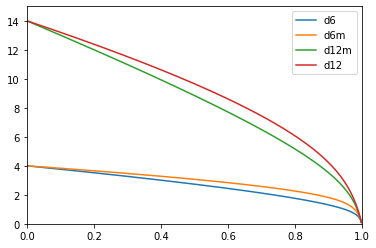

In [10]:
csv = pd.read_csv("hetero1_100.csv")
plot(csv['rho'].values, 1 / csv['d6'].values, label="d6")
plot(csv['rho'].values, 1 / csv['d6m'].values, label="d6m")
plot(csv['rho'].values, 1 / csv['d12m'].values, label="d12m")
plot(csv['rho'].values, 1 / csv['d12'].values, label="d12")
xlim([0, 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, 15) )  # set the ylim to ymin, ymax
legend()
show()

### Rmpact of population distribution

In [11]:
#def diff_study2(S = 100, ρ = .9, step=.005):
S = 100
step = .001
ρl = .2
ρm = .9
ρh = .99

pp = arange(step, 1, step)
R = len(pp)
d6l = zeros(R)
d12l = zeros(R)
d6m = zeros(R)
d12m = zeros(R)
d6h = zeros(R)
d12h = zeros(R)

classe = [4, 8]

for i,p in enumerate(pp):
    trash1,trash2,d = differentiated(S, classe, [p, 1-p], ρl)
    d6l[i] = d[0]
    d12l[i] = d[1]
    trash1,trash2,d = differentiated(S, classe, [p, 1-p], ρm)
    d6m[i] = d[0]
    d12m[i] = d[1]
    trash1,trash2,d = differentiated(S, classe, [p, 1-p], ρh)
    d6h[i] = d[0]
    d12h[i] = d[1]
csv = pd.DataFrame({'p': pp, 'd6l': d6l, 'd12l': d12l, 'd6m': d6m, 'd12m': d12m, 'd6h': d6h, 'd12h': d12h})
fn = "hetero2.csv"
csv.to_csv(fn, index=False)    

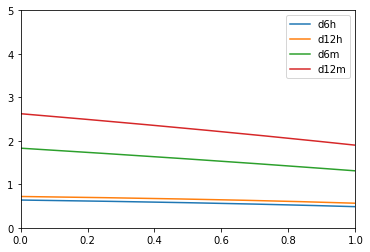

In [12]:
csv = pd.read_csv("hetero2.csv")
plot(csv['p'].values, 1 / csv['d6h'].values, label="d6h")
plot(csv['p'].values, 1 / csv['d12h'].values, label="d12h")
plot(csv['p'].values, 1 / csv['d6m'].values, label="d6m")
plot(csv['p'].values, 1 / csv['d12m'].values, label="d12m")
xlim([0, 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, 5) )  # set the ylim to ymin, ymax
legend()
show()

## 4. Rmpact of locality (Subsection 6.4.2)

### Cost of heterogeneity and locality

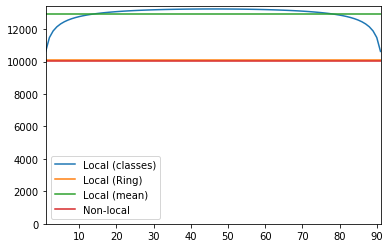

In [13]:
S = 100
d = 10
ρ = .9999

Ls = Li_local(S, d, ρ)
ring_delay = R_local(S, d, ρ)
range_a = L_local(S, d, ρ)
range_i = Ls * (S - d + 1)
R = homogeneous(S, d, ρ)

plot(range(1, S - d + 2), range_i, label="Local (classes)")
plot([1, S - d + 1], ring_delay * ones(2), label="Local (Ring)")
plot([1, S - d + 1], range_a * ones(2), label="Local (mean)")
plot([1, S - d + 1], R * ones(2), label="Non-local")
xlim([1, S - d + 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, ymax) )  # set the ylim to ymin, ymax
legend()
show()

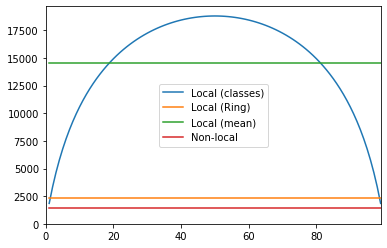

In [14]:
S = 100
d = 2
ρ = .999

Ls = Li_local(S, d, ρ)
ring_delay = R_local(S, d, ρ)
range_a = L_local(S, d, ρ)
range_i = Ls * (S - d + 1)
R = homogeneous(S, d, ρ)

plot(range(1, S - d + 2), range_i, label="Local (classes)")
plot([1, S - d + 1], ring_delay * ones(2), label="Local (Ring)")
plot([1, S - d + 1], range_a * ones(2), label="Local (mean)")
plot([1, S - d + 1], R * ones(2), label="Non-local")
xlim([0, S - d + 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, ymax) )  # set the ylim to ymin, ymax
legend()
show()

In [15]:
def load_study(S = 100, d=10, ρ = .9):
    c = arange(1, S - d + 2)
    Li = Li_local(S, d, ρ) * (S - d + 1) / S / ρ
    L = L_local(S, d, ρ) / S / ρ * ones(S-d+1)
    R = R_local(S, d, ρ) / S / ρ * ones(S-d+1)
    G = homogeneous(S, d, ρ) / S / ρ * ones(S - d + 1)
    csv = pd.DataFrame({'c': c, 'Li': Li, 'L': L, 'R': R, 'G': G})
    fn = "load_study_S_" + str(S) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv"
    csv.to_csv(fn, index=False)    

In [16]:
def plot_local_study(S = 100, d = 10, ρ = .9):
    try:
        csv = pd.read_csv("load_study_S_" + str(S) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study(S, d, ρ)
        csv = pd.read_csv("load_study_S_" + str(S) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv")
    plot(csv['c'].values, csv['Li'].values, label="Local (classes)")
    plot(csv['c'].values, csv['R'].values, label="Local (Ring)")
    plot(csv['c'].values, csv['L'].values, label="Local (mean)")
    plot(csv['c'].values, csv['G'].values, label="Non-local")
    xlim([1, S - d + 1])
    ymin, ymax = ylim()   # return the current ylim
    ylim( (0, ymax) )  # set the ylim to ymin, ymax
    legend()
    show()

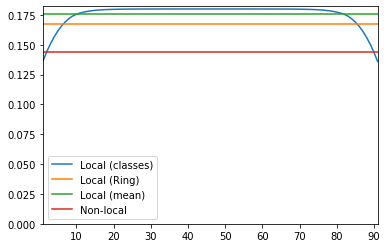

In [17]:
plot_local_study(ρ=.5)

### Rmpact of the parameters

#### Load $\rho$

In [18]:
import pandas as pd
def load_study_rho(S=100, d=10, step=.001):
    ρρ = arange(step, 1, step)
    R = len(ρρ)
    L = zeros(R)
    R = zeros(R)
    G = zeros(R)
    for i,ρ in enumerate(ρρ):
        norm = S * ρ
        L[i] = L_local(S, d, ρ) / norm
        R[i] = R_local(S, d, ρ) / norm
        G[i] = homogeneous(S, d, ρ) / norm
    csv = pd.DataFrame({'rho': ρρ, 'L': L, 'R': R, 'G': G})
    fn = "load_study_rho_S_" + str(S) + "_d_" + str(d) + ".csv"
    csv.to_csv(fn, index=False)    

In [19]:
def plot_local_study_rho(S=100, d=10, step=.001):
    try:
        csv = pd.read_csv("load_study_rho_S_" + str(S) + "_d_" + str(d) + ".csv")
    except:
        load_study_rho(S, d, step)
        csv = pd.read_csv("load_study_rho_S_" + str(S) + "_d_" + str(d) + ".csv")
    plot(csv['rho'].values, csv['R'].values, label="Ring")
    plot(csv['rho'].values, csv['L'].values, label="Local")
    plot(csv['rho'].values, csv['G'].values, label="Non-local")
    xlim([0,1])
    ymin, ymax = ylim()   # return the current ylim
    ylim( (0, 2) )  # set the ylim to ymin, ymax
    legend()
    show()

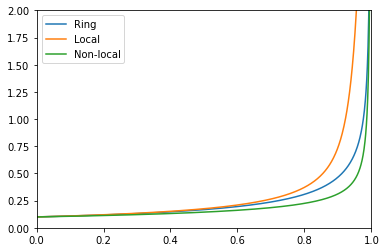

In [20]:
plot_local_study_rho(100, 10, step=.001)

#### Parallelism degree $d$

In [21]:
def load_study_d(S=100, ρ=.9):
    dd = arange(1, S+1)
    R = len(dd)
    L = zeros(R)
    R = zeros(R)
    G = zeros(R)
    for i,d in enumerate(dd):
        norm = S * ρ
        L[i] = L_local(S, d, ρ) / norm
        R[i] = R_local(S, d, ρ) / norm
        G[i] = homogeneous(S, d, ρ) / norm
    csv = pd.DataFrame({'d': dd, 'L': L, 'R': R, 'G': G})
    fn = "load_study_d_S_" + str(S) + "_rho_" + str(ρ) + ".csv"
    csv.to_csv(fn, index=False)    

In [22]:
def plot_local_study_d(S=100, ρ=.9):
    try:
        csv = pd.read_csv("load_study_d_S_" + str(S) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study_d(S, ρ)
        csv = pd.read_csv("load_study_d_S_" + str(S) + "_rho_" + str(ρ) + ".csv")
    plot(csv['d'].values, csv['R'].values, label="Ring")
    plot(csv['d'].values, csv['L'].values, label="Local")
    plot(csv['d'].values, csv['G'].values, label="Non-local")
    xlim([1,S])
    ymin, ymax = ylim()   # return the current ylim
    ylim( (0, 2) )  # set the ylim to ymin, ymax
    legend()
    show()

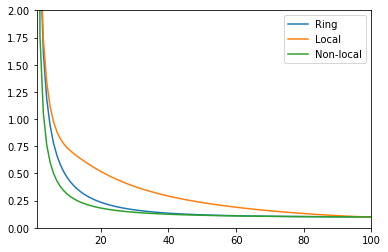

In [23]:
plot_local_study_d(100, .9)

#### Number $S$ of servers

In [24]:
def load_study_S(Smax=100, d=10, ρ=.9):
    SS = arange(d + 1, Smax + 1)
    R = len(SS)
    L = zeros(R)
    R = zeros(R)
    G = zeros(R)
    for i, S in enumerate(SS):
        norm = S * ρ
        L[i] = L_local(S, d, ρ) / norm
        R[i] = R_local(S, d, ρ) / norm
        G[i] = homogeneous(S, d, ρ) / norm
    csv = pd.DataFrame({'S': SS, 'L': L, 'R': R, 'G': G})
    fn = "load_study_S_Smax_" + str(Smax) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv"
    csv.to_csv(fn, index=False)    

In [25]:
def plot_local_study_S(Smax=100, d=10, ρ=.9):
    try:
        csv = pd.read_csv("load_study_S_Smax_" + str(Smax) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study_S(Smax, d, ρ)
        csv = pd.read_csv("load_study_S_Smax_" + str(Smax) + "_d_" + str(d) + "_rho_" + str(ρ) + ".csv")
    plot(csv['S'].values, 1 / csv['R'].values, label="Ring")
    plot(csv['S'].values, 1 / csv['L'].values, label="Local")
    plot(csv['S'].values, 1 / csv['G'].values, label="Non-local")
    xlim([d + 1, Smax])
    ymin, ymax = ylim()   # return the current ylim
    ylim( (0, 2) )  # set the ylim to ymin, ymax
    legend()
    show()

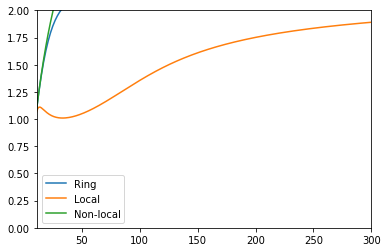

In [26]:
plot_local_study_S(300)

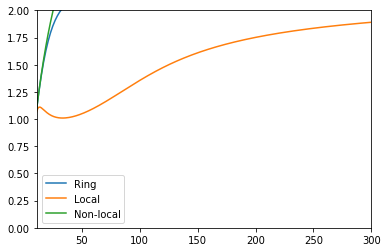

In [27]:
plot_local_study_S(300)